In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pathlib
import matplotlib.pyplot as plt
import os
import json
import sys
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split
import torch.utils.data as data
import numpy as np
import pickle
import collections
import pandas as pd
import csv

In [44]:
home_dir = pathlib.Path.home().joinpath('PycharmProjects', 'one_shot_ppi')
embedding_path = pathlib.Path.joinpath(home_dir, 'dataset', 'embeddings', 'per_prot_emb_full.p')
model_name = 'siameseNet_dropout_contrastive_128'
with open(embedding_path, 'rb') as fp:
    embeddings = pickle.load(fp)

In [45]:
import torch.nn.functional as F
import torch.nn as nn
import torch
from torch import abs


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # conv2d(input_channels, output_channels, kernel_size)
        self.dropout1 = nn.Dropout(0.3)
        # self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(1 * 1024, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fcOut = nn.Linear(32, 1)
        # define batchnorm
        #self.bn1 = nn.BatchNorm1d(num_features=256)
        # self.sigmoid = nn.Sigmoid()
        #self.tanh = nn.Tanh()

    def forward_once(self, input):
        #print(input)
        #print(input.shape)
        x = input
        # x = self.dropout1(F.relu(self.fc1(x)))
        # x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.fc1(x))
        x = self.dropout1(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        # x = self.fc3(x)
        # x = abs(x1 - x2)
        # x = F.tanh(self.fcOut(x))
        x = self.fcOut(x)
        return x

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2


In [46]:
class Dataset(data.Dataset):
    # characterizes a dataset for PyTorch
    def __init__(self, list_IDs, pairs, labels, embeddings):
        self.list_IDs = list_IDs
        self.labels = labels
        self.pairs = pairs
        self.embeddings = embeddings

    def __len__(self):
        return len(self.list_IDs)

    def __getitem__(self, index):
        # generates one sample of data
        # select sample
        ID = self.list_IDs[index]
        x1 = self.pairs[ID][0]
        x1_t = torch.Tensor(self.embeddings[x1])
        x2 = self.pairs[ID][1]
        x2_t = torch.Tensor(self.embeddings[x2])
        # load data and get label
        y = self.labels[ID]

        return x1_t, x2_t, torch.from_numpy(np.array([y], dtype=np.float32)), x1, x2

In [47]:
# parameters
params = {'batch_size': 1,
         'shuffle': False,
         'num_workers': 0}

test_data = pathlib.Path.joinpath(home_dir, 'dataset', 'test', 'c1_test.json')
test_l = pathlib.Path.joinpath(home_dir, 'dataset', 'test', 'c1_label.json')

with open(test_data, 'r') as fp:
    test_pairs = json.load(fp)
with open(test_l, 'r') as fp:
    test_labels = json.load(fp)

    
list_IDs_test = list(test_pairs.keys())

# Generators
test_set = Dataset(list_IDs_test, test_pairs, test_labels, embeddings)
test_loader = torch.utils.data.DataLoader(test_set, **params)

In [48]:
def load_checkpoint(model, optimizer):
    state_dict = torch.load(save_path)
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    val_loss = state_dict['val_loss']
    print(f'Model loaded from <== {save_path}')
    
    return val_loss

In [49]:
#creating the original network and couting the paramenters of different networks
PATH = pathlib.Path.joinpath(home_dir, 'trained_models')
model_path = pathlib.Path.joinpath(PATH, model_name + '.pt')
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.__version__)
model = Net()
optimizer = optim.Adam(model.parameters(), lr = 0.0006)
state_dict = torch.load(model_path)
model.load_state_dict(state_dict['model_state_dict'])
model.to(device)
model.eval()

cuda:0
1.5.0


Net(
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=32, bias=True)
  (fcOut): Linear(in_features=32, out_features=1, bias=True)
)

In [50]:
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(pytorch_total_params)

299457


In [51]:
def test_eval(model, test_loader, model_name):
    result_df = pd.DataFrame(columns=['int_A', 'int_B', 'target', 'distance', 'predicted'])
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    distance = []
    target = []
    int_A = []
    int_B = []
    for i, data in enumerate(test_loader,0):
        x0, x1 , label, pA, pB = data
        int_A.append(pA[0])
        int_B.append(pB[0])
        target.append(label.cpu().data.numpy()[0][0])
        # perform inference
        output1, output2 = model(x0.to(device),x1.to(device))
        # calculate L2 distance
        d = (output2 - output1).pow(2).sum(1)
        distance.append(d.cpu().data.numpy()[0])
        
    # populate dataframe
    result_df['int_A'], result_df['int_B'] = int_A, int_B
    result_df['target'], result_df['distance'] = target, distance
        
    return result_df

In [52]:
result_df = test_eval(model, test_loader, model_name)

In [53]:
margin = 0.8
t_l = []
d = result_df['distance']
for i in d:
    if i < margin:
        t_l.append(1.0)
    else:
        t_l.append(0.0)
result_df['predicted'] = t_l
result_df        

,int_A,int_B,target,distance,predicted
0,Q9BQ52,O95182,1.0,0.000064,1.0
1,P22307,P69976,1.0,0.213568,1.0
2,O60763,Q8ZIX0,1.0,0.813260,0.0
3,P23434,Q13287,1.0,2.774438,0.0
4,Q14978,P38432,1.0,0.083580,1.0
...,...,...,...,...,...
1206,Q99689,Q8WVB3,0.0,4.276834,0.0
1207,Q8NG31,Q99933,0.0,2.161904,0.0
1208,Q16394,P16219,0.0,0.812224,0.0
1209,Q9BUZ4,Q969Y2,0.0,2.842969,0.0


In [30]:
# save predictions
path = pathlib.Path.cwd().joinpath('predictions', model_name + '.csv')
result_df.to_csv(path, index=False)

<Figure size 1080x1080 with 0 Axes>

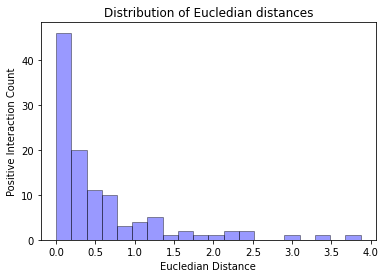

<Figure size 1080x1080 with 0 Axes>

In [46]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib histogram
#plt.hist(pos_dist, color = 'blue', edgecolor = 'black', bins = 12)

pos_dist = []
neg_dist = []
lbl = list(result_df['target'])
dist_val = list(result_df['distance'])
for i in range(len(lbl)):
    if lbl[i] == 1:
        pos_dist.append(dist_val[i])
    else:
        neg_dist.append(dist_val[i])
# seaborn histogram
fig = sns.distplot(pos_dist, hist=True, kde=False, 
             bins=20, color = 'blue',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Eucledian distances')
plt.xlabel('Eucledian Distance')
plt.ylabel('Positive Interaction Count')
plt.figure(figsize=(15,15))


In [51]:
loss_path = pathlib.Path.cwd().joinpath('loss_list', 'val_loss_list.csv')
loss_list = []
with open(loss_path, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    for row in csvreader:
        loss_list.append(row)
s = loss_list[0]
val_list = []
for i in s:
    val_list.append(float(i))
    
val_list[0]

0.8097614441756849

In [53]:
loss_path_2 = pathlib.Path.cwd().joinpath('loss_list', '2. val_loss_list.csv')
loss_list_2 = []
with open(loss_path_2, newline='') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',', quoting=csv.QUOTE_NONNUMERIC)
    for row in csvreader:
        loss_list_2.append(row)
s_2 = loss_list_2[0]
val_list_2 = []
for i in s_2:
    val_list_2.append(float(i))
    
print(len(val_list_2))

50


0.733956748932523


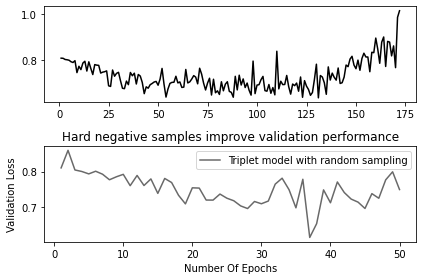

<Figure size 1440x1440 with 0 Axes>

In [69]:
param_range = np.arange(1, 173, 1)
param_range_2 = np.arange(1,51,1)

# Calculate mean and standard deviation for training set scores
train_mean = np.mean(val_list, axis=0)
train_std = np.std(val_list, axis=0)

print(train_mean)

# Calculate mean and standard deviation for test set scores
test_mean = np.mean(val_list_2, axis=0)
test_std = np.std(val_list_2, axis=0)

fig, axs = plt.subplots(2)
#plt.subplot(1,2,1)
# Plot mean accuracy scores for training and test sets
axs[0].plot(param_range, val_list, label="Triplet model with hard and semi-hard negative samples", color="black")
#plt.subplot(1,2,2)
axs[1].plot(param_range_2, val_list_2, label="Triplet model with random sampling", color="dimgrey")

# Plot accurancy bands for training and test sets
#plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, color="gray")
#plt.fill_between(param_range_2, test_mean - test_std, test_mean + test_std, color="gainsboro")

# Create plot
plt.title("Hard negative samples improve validation performance")
plt.xlabel("Number Of Epochs")
plt.ylabel("Validation Loss")
plt.tight_layout()
plt.legend(loc="best")
plt.savefig('val_loss.jpg', dpi=125)
plt.figure(figsize=(20, 20))

plt.show()
#plt.draw()